In [1]:
import sys
sys.path.append('../../../../')
sys.path.append('../../../')
from plot_tools.fig_preamble import * # imports numpy, matplotlib, Py2PDF, plot_helper_funcs, plot_figstyle_sheet
% matplotlib inline

from scipy.signal import decimate
from single_shot_filtering import one_shot_msmt, plot_stats, low_pass_filter, set_fft_zero
from plot_tools.plot_figstyle_sheet import color_pallete

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


Paths

In [2]:
ver=0
datapath = '../../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig = '../svg/poster_2017_07_08_'
figname = 'decimatesingleshots'

Consider the total phase accumulated on a qubit due to its interacting with slowly varying noise: for a single value of detuning and a single wait time in a Ramsey experiment:

In [3]:
detuning_0 = 2.
tau_0 = 10**-5

Let's fix $\tau$ at some multiple of $\tau_0$

In [4]:
tau_fixed = tau_0*200
print tau_fixed

0.002


Define a linear ramp in detuning (We can also test for jitter, and chirped (slowly varying) detuning):

In [5]:
detuning_trace = detuning_0*(np.arange(0,200, 1))

Define a function to help us stop our analysis if $\psi(t) \equiv \int_0^\tau \beta(t) dt > \pi$ :

In [6]:
def truncate_phases(phase_):
    for idx_phase in xrange(phase_.shape[0]):
        if phase_[idx_phase] > np.pi:
            break
    return idx_phase

Low pass filtering often gives artefacts near zero (e.g. butterworth). Add a random phase offset so that we shift $P(\tau, \beta$ is an unsual shape, and that low pass filtering features are not accidentally mis interpreted as following the true probability trace.

In [7]:
offset = 0.8*np.pi

Calculate phases and stop taking data if total phase (minus offset) is more than pi:

In [8]:
phase = tau_fixed*2.0*np.pi*detuning_trace + offset
idx_max = truncate_phases(phase-offset) # max index beyond which inference makes no sense
print idx_max

126


The true theoretical trace can be modelled as a cosine at $\tau n$ sample points for $n \in [0, N]$, N = idx_max

In [9]:
_theory = 0.5*np.cos(phase[:idx_max]) + 0.5

Use these probabilities to define the bias in binomial distribution ( i.e. take biased coin tosses, where the bias varies):

In [10]:
single_shot_msmts_B = np.random.binomial(n=1, p=_theory)

Roughly implement decimate filter (trial and error):

In [11]:
fs = 1./tau_fixed
print "Sampling freq", fs

Sampling freq 500.0


But the hidden change in detuning (for a linear ramp), is the true detuning_0. We are sufficiently oversampled to resolve this via a decimation filter i.e. decimation factor > fs/detuning_0

In [12]:
print "Detuning stepsize", detuning_0
max_decimatonfactor = (1./tau_fixed) / detuning_0
print "True max decimator factor", max_decimatonfactor

Detuning stepsize 2.0
True max decimator factor 250.0


In [13]:
dec_factor = 4
decimate_order = 5
# Type 1 filter used: pass band ripple, with no phase shift is desired compared to greater stop band ripples (in Type II)
# In Type 1 filters, decimate_order < 13
signal_d = decimate(single_shot_msmts_B, dec_factor, decimate_order, zero_phase=True)

Note that the time axis is in steps of $\tau$ at which we do consecutive Ramsey experiments:

In [14]:
tau_N_axis = tau_fixed*np.arange(idx_max)
_time_step = tau_fixed
_time_axis = tau_N_axis / tau_fixed

But in the graph of $P(\Delta, \tau)$ against $\Delta$ detuning, our fixed $\tau$ is the 'frequency' of the half cosine curve that should be traced out (for total phase less than pi). Note that if sufficently sampled, you only need 25% of a cosine curve to reconstruct the entire curve. Hence, for sufficient oversampling rates, the decimation filter should work:

In [15]:
_freq = tau_fixed

Plot and save:

0
1


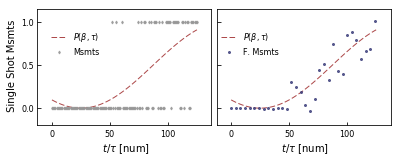

In [16]:
from matplotlib.ticker import MaxNLocator

gs = gridspec.GridSpec(nrows=1, ncols=2, top=0.95, bottom=0.2, left=0.1, right=0.99, wspace=0.03, hspace=0.5)

fig = plt.figure(figsize=(cm2inch(14),cm2inch(5.5)))
ax_0 = fig.add_subplot(gs[0, 0])
ax_1 = fig.add_subplot(gs[0, 1])

axes = [ax_0, ax_1]
data = [single_shot_msmts_B, signal_d] # collate data for plotting
ax_0.set(ylabel=r' Single Shot Msmts')
#ax_1.set(ylabel=r' Filtered Msmts')

ax_0.legend(handles= ONESHOT_H[0:2], labels=ONESHOT_L[0:2], 
          bbox_to_anchor=(0.0, 0.65, 0.4, .102), fontsize=fsize,
          loc=5, frameon=False)

ax_1.legend(handles= ONESHOT_H[0::2], labels=ONESHOT_L[0::2], 
          bbox_to_anchor=(0.0, 0.65, 0.4, .102), fontsize=fsize,
          loc=5, frameon=False)
ax_1.set(yticklabels=[])
for idx_data in xrange(len(axes)):
    
    ax = axes[idx_data]
    ax.set_ylim([-0.2,1.15])
    ax.tick_params(labelsize=fsize, direction='in')
    
    
    ax.plot(_time_axis, _theory, '--', c=color_pallete[13], lw=1)
    print idx_data
    
    if idx_data < 1:
        ax.plot(_time_axis, data[idx_data], 'd', c=color_pallete[37], 
                alpha=0.8, markersize=2)
    
    if idx_data ==1:
        _time_axis = dec_factor*_time_axis[0:data[idx_data].shape[0]]
        ax.plot(_time_axis, data[idx_data], 'o', c=color_pallete[0], 
                alpha=0.8, markersize=2)
    
    #ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.margins(0.1)
    ax.set(xlabel=r' $t/\tau$ [num]')
    ax = set_font_sizes(ax, fsize, Fsize)
    
    ax.xaxis.set_major_locator( MaxNLocator(nbins = 3) )
    ax.yaxis.set_major_locator( MaxNLocator(nbins = 3) )
    


fig.savefig(savefig+figname+'.svg', format='svg', dpi=my_dpi)
plt.show()
plt.close()